1. Необходимо скачать и подготовить датасет
https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks
для обучения модели на сегментацию губ (обратите внимание, что сегментация
подразумевает уже два класса: фон и губы).
2. И затем обучить Модель на выбор из segmentation_models_pytorch

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from IPython.display import clear_output

In [4]:
data_root = '/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original/'

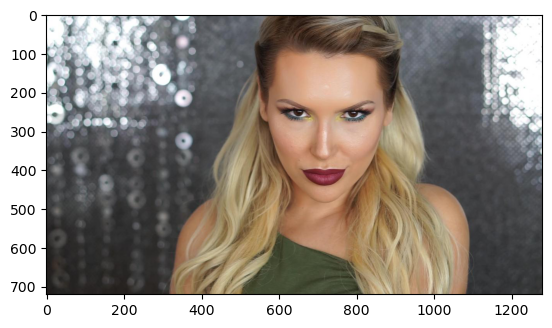

In [5]:
# Original image

plt.imshow(plt.imread(data_root + '720p/image00000001.jpg'))
plt.show()

In [6]:
labels = ['Background', 'Lips'] # 2 class

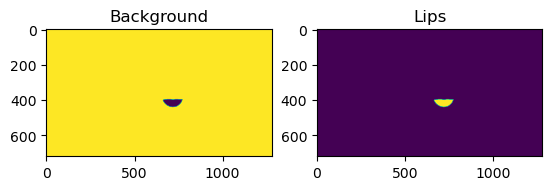

In [7]:
mask = plt.imread(data_root + '/mask/mask00000001.png')[..., 1]
plt.subplot(1, 2, 1)
plt.title(labels[0])
plt.imshow(np.where(mask <= 0.5, 255, 0))
plt.subplot(1, 2, 2)
plt.title(labels[1])
plt.imshow(np.where(mask >= 0.5, 255, 0))
plt.show()

In [8]:
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torch.nn import functional as F

In [9]:
data_list = pd.read_csv(data_root + '/list.csv')

data_list.drop(index=[i for i in range(10700, 11000)], inplace=True) # так как часть масок отсутствует в заданном промежутке

data_list.head(2)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png


In [10]:
class LipsDataset(Dataset):
    def __init__(self, data, transform=None):
        
        self.image_root = data.iloc[:, 0]
        
        self.mask_root = data.iloc[:, -1]
        
        self.len_data = len(data)
        
        self.preprocessing = transform
        
        
    def __getitem__(self, idx):
        img = cv2.cvtColor(cv2.imread(data_root + '/720p/' + self.image_root[idx]),
                           cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        img = np.asarray(img).astype(float)

        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)

        else:
            img = torch.as_tensor(img) / 255.0 # normalization [0, 1]

        img = torch.permute(img, (2, 0, 1))

        # masks
        masks = []

        mask = cv2.cvtColor(cv2.imread(data_root + '/mask/' + self.mask_root[idx]), cv2.COLOR_BGR2RGB)
        
        # label 0
        cls_mask = np.where(mask <= 100, 255, 0)
        cls_mask = cls_mask.astype('float')
        cls_mask = cv2.resize(cls_mask, (256, 256))

        masks.append(cls_mask[:, :, 1] / 255)

        # label 1
        cls_mask = np.where(mask > 100, 255, 0)
        cls_mask = cls_mask.astype('float')
        cls_mask = cv2.resize(cls_mask, (256, 256))
        masks.append(cls_mask[:, :, 1] / 255)

        masks = torch.as_tensor(masks, dtype=torch.uint8)

        return (img.float(), masks)


    def __len__(self):
        return self.len_data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)


torch.Size([3, 256, 256])
torch.Size([2, 256, 256])


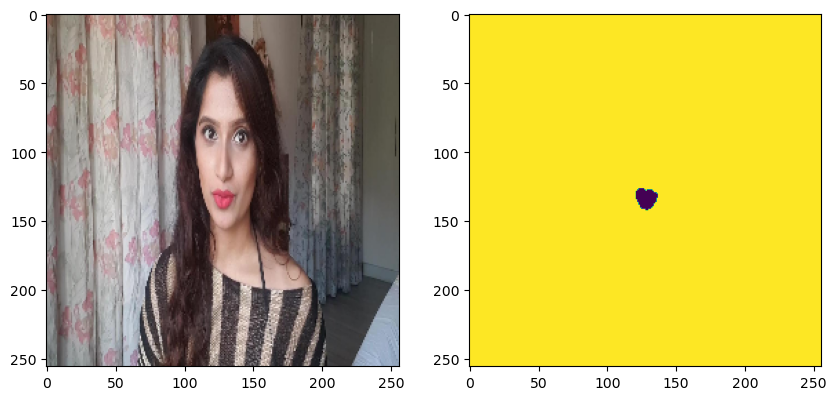

In [11]:
dataset = LipsDataset(data_list)
img, masks = dataset[2000]
print(img.shape)
print(masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0)[..., 0])
plt.show()

In [15]:
# !pip install git+https://github.com/qubvel/segmentation_models.pytorch

# clear_output()

In [16]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils

In [17]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu:0'

In [138]:
backbone = 'resnet18'

unet_model = smp.Unet(encoder_name=backbone,
                     classes=2, activation='softmax2d').to(device)

preprocess_input = smp.encoders.get_preprocessing_fn(backbone, pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [139]:
criterion = smp_utils.losses.DiceLoss()
metrics = [smp_utils.metrics.IoU()]

optimizer = torch.optim.Adam(params=unet_model.parameters(), lr=0.001)

In [140]:
train_epoch = smp_utils.train.TrainEpoch(
    unet_model, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp_utils.train.ValidEpoch(
    unet_model, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [141]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(data_list.loc[data_list.index < 5000], test_size=0.3)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

train_data = LipsDataset(X_train)
test_data = LipsDataset(X_test)

In [142]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

torch.Size([16, 3, 256, 256]) torch.Size([16, 2, 256, 256])
tensor(0.0157) tensor(1.)
tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


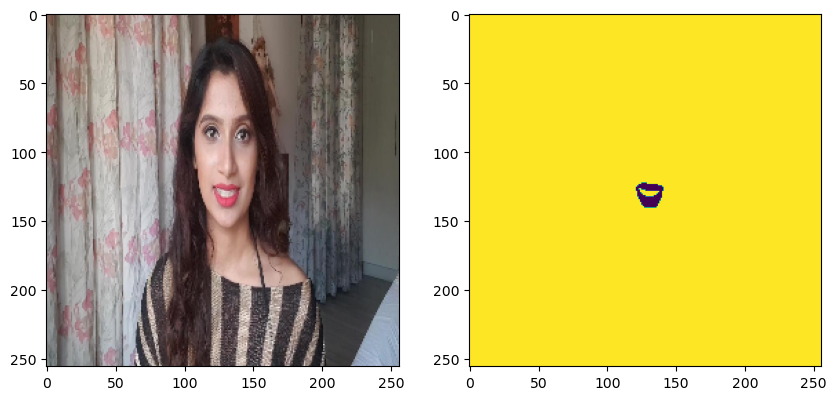

In [143]:
for img, target in train_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[1].imshow(target[0].permute(1, 2, 0)[..., 0])
    break

In [144]:
# train model

max_score = 0

for i in range(0, 5):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(test_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(fpn_model, './best_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████| 188/188 [01:42<00:00,  1.84it/s, dice_loss - 0.002221, iou_score - 0.9984]
Model saved!
Epoch: 2
valid: 100%|██████████| 188/188 [01:25<00:00,  2.19it/s, dice_loss - 0.000826, iou_score - 0.9993] 
Model saved!
Epoch: 3
valid: 100%|██████████| 188/188 [01:27<00:00,  2.15it/s, dice_loss - 0.0005355, iou_score - 0.9994]
Model saved!
Epoch: 4
valid: 100%|██████████| 188/188 [01:27<00:00,  2.16it/s, dice_loss - 0.0004564, iou_score - 0.9994]
Epoch: 5
valid: 100%|██████████| 188/188 [01:27<00:00,  2.15it/s, dice_loss - 0.0003561, iou_score - 0.9995]
Model saved!


In [145]:
save_model_path = './Unet_Model_dice_loss.pth'

torch.save(unet_model, save_model_path)

In [146]:
net = torch.load(save_model_path)

In [147]:
def get_orig(image):
    image = image.permute(1, 2, 0)
    image = image.numpy()
    image = np.clip(image, 0, 1)
    return image

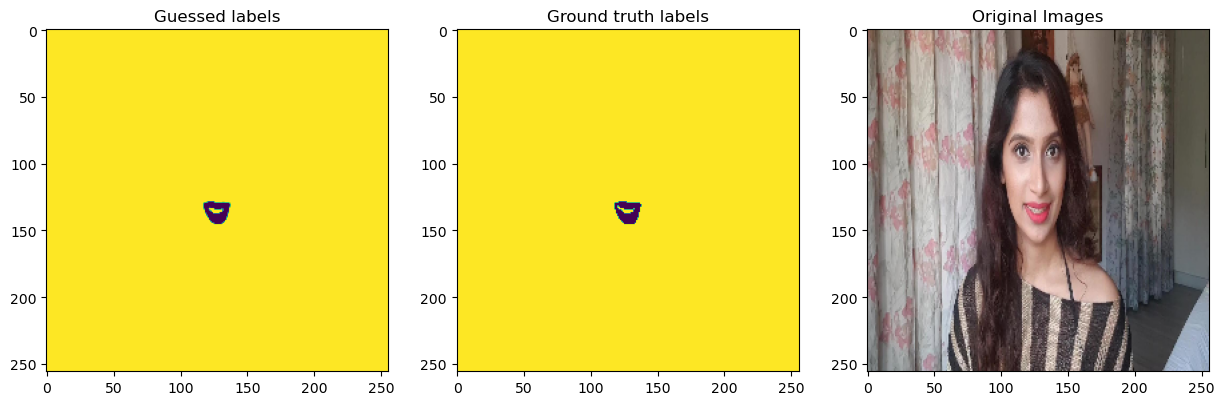

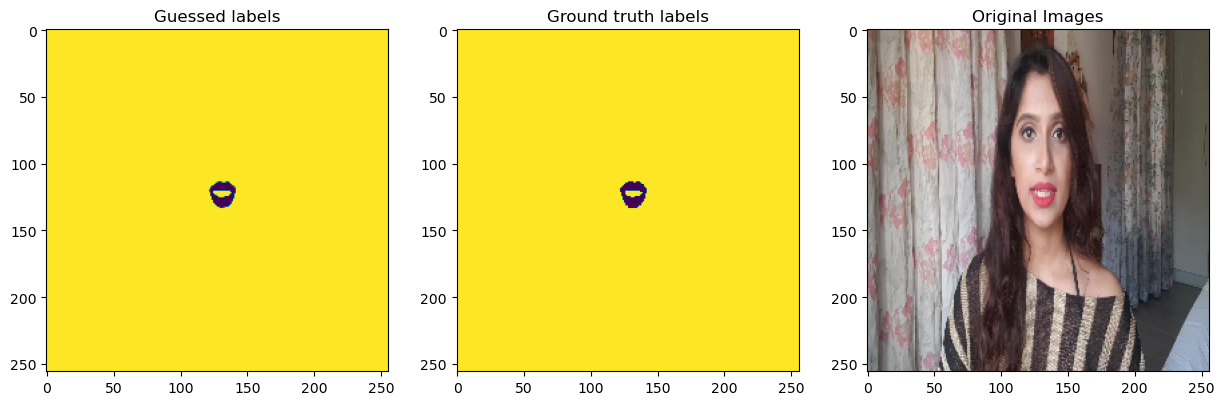

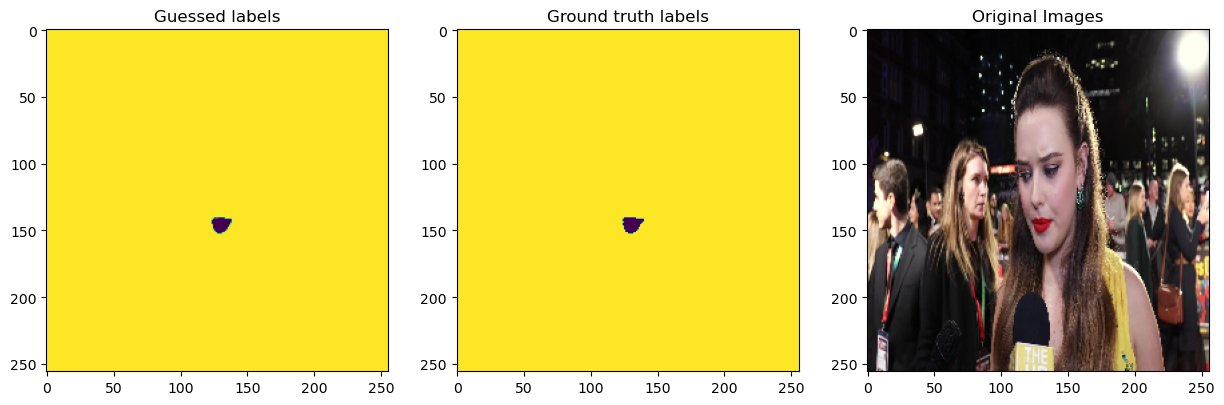

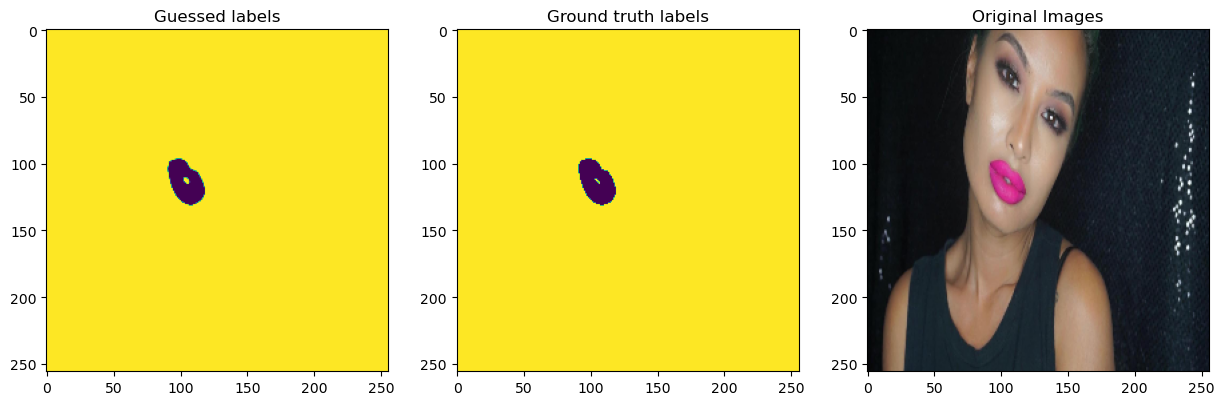

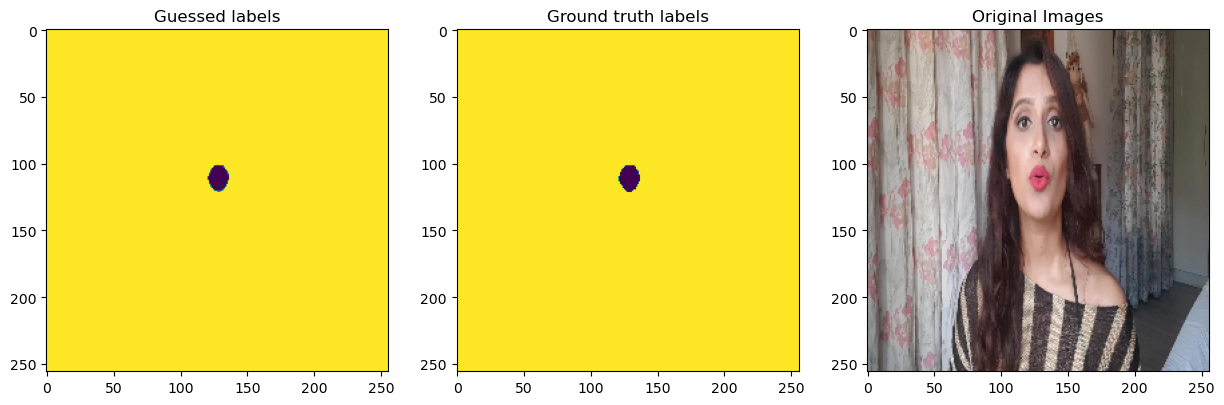

In [148]:
class_idx = 0

for i, data in enumerate(test_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = net(images)
    f, axarr = plt.subplots(1,3, figsize=(15, 6))

    for j in range(0, 4):
        axarr[0].imshow(outputs.detach().cpu().numpy()[j, class_idx, :,:])
        axarr[0].set_title('Guessed labels')
        axarr[1].imshow(labels.detach().cpu().numpy()[j,class_idx, :,:])
        axarr[1].set_title('Ground truth labels')

        original = get_orig(images[j].cpu())
        axarr[2].imshow(original)
        axarr[2].set_title('Original Images')
        plt.show()
    if i > 3:
        break